# **[PlantVillage Disease Classification Challenge](https://www.crowdai.org/challenges/plantvillage-disease-classification-challenge)**

PlantVillage is built on the premise that all knowledge that helps people grow food should be openly accessible to anyone on the planet.

**Overview**

We depend on edible plants just as we depend on oxygen. Without crops, there is no food, and without food, there is no life. It's no accident that human civilization began to thrive with the invention of agriculture.

Today, modern technology allows us to grow crops in quantities necessary for a steady food supply for billions of people. But diseases remain a major threat to this supply, and a large fraction of crops are lost each year to diseases. The situation is particularly dire for the 500 million smallholder farmers around the globe, whose livelihoods depend on their crops doing well. In Africa alone, 80% of the agricultural output comes from smallholder farmers.

With billions of smartphones around the globe, wouldn't it be great if the smartphone could be turned into a disease diagnostics tool, recognizing diseases from images it captures with its camera? This challenge is the first of many steps turning this vision into a reality. PlantVillage is a not-for-profit project by Penn State University in the US and EPFL in Switzerland. We have collected - and continue to collect - tens of thousands of images of diseased and healthy crops. ***The goal of this challenge is to develop algorithms than can accurately diagnose a disease based on an image.***

Here are the 38 classes of crop disease pairs that the dataset is offering.  To learn more about the background of the dataset, please refer to the following paper: https://arxiv.org/abs/1511.08060v2. You must cite this paper if you use the dataset. 



**Evaluation**

Submissions will be evaluated using a Multi Class Log Loss evaluation function.

In [1]:
import os
import pandas as pd
import numpy as np
import random
import cv2
import pathlib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import SVG
import IPython.display as display

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import warnings
warnings.filterwarnings("ignore")

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


import keras.backend as K
from keras.models import Sequential

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

import time as tm

Using TensorFlow backend.


Next will be show few images samples from the data set:

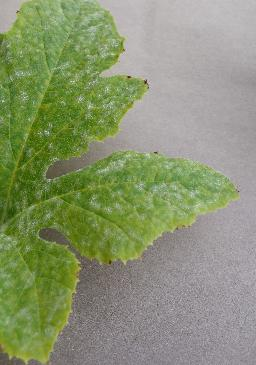

['c_25', '69165975-b7d8-4edd-8516-6218f2c6560b___UMD_Powd.M 9877.JPG']


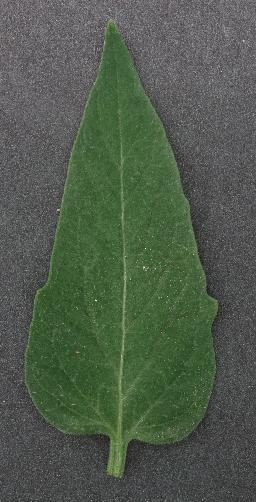

['c_37', 'd88b90c0-2850-425d-af82-7bfb0f6a9dd4___GH_HL Leaf 361.JPG']


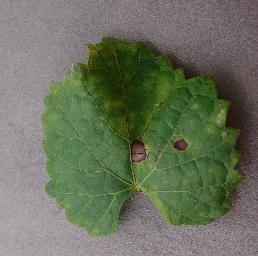

['c_11', '50911cb0-4fc0-4403-b42d-d21b60b76ed6___FAM_B.Rot 0422.JPG']


In [2]:
rootDir = 'crowdai'
data_root = pathlib.Path(rootDir)
all_image_paths = list(data_root.glob('*/*'))
for i in range(0,3):
    image_example = str(random.choice(all_image_paths))
    display.display(display.Image(image_example))
    print(image_example.split("/")[-2:])
# The first value correspond to folder name and it is its label, next values is the file name

The first value correspond image folder name and it's its label, and next value is the file name

# Load data and create labels

- Create function to read the files in root, and get a list with labels and image names.

After several attempts, and try different aproach, I  choose this way, because the way of dataframe was created keep the same read system order, because the classes or labels are in the same order that jupyter is reading the data, and the code is more clean than other approachs I did tested. I like this consistency, even though the data reading is more slow, but I'm keeping this approach for this work.

In [3]:
def make_labels(rootDir):
    '''
    From a given root, this function return a pandas dataframe with the classes and file names
    The data read is slow but it garanties the order in pandas, as pc read the files.
    inpu:
        rootDir: Root dir which contains the files by classes folder names
    return:
        d: Is an empty dataframe, wich is populated by files names and ist respective classes.
    '''
    df = pd.DataFrame()   
    idx = 0 
    for lists in os.listdir(rootDir): 
        path = os.path.join(rootDir, lists)
        aux_list = []
        for path, dirs, files in os.walk(path):
            key = path.split("/")[-1:][0]
            for file in files:
                temp = pd.DataFrame({'label': key, 'img':file},index=[idx])
                idx +=1
                df = pd.concat([df, temp])
    return df


The next are the function test, in order to get classes and files names from folders.

In [4]:
df = make_labels(rootDir)
df.head()

,label,img
0,c_1,f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE...
1,c_1,73b7ad12-02d0-4775-8f51-c7d404177132___JR_FrgE...
2,c_1,50afe8c7-d56e-4dd0-97b8-23a70ddca819___JR_FrgE...
3,c_1,1ce4ecdf-fe69-42df-a0dc-c90f5495e7a1___JR_FrgE...
4,c_1,464511a6-77d9-493f-bb3c-f151fb390f1b___JR_FrgE...


In [5]:
# Read file function

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (64, 64), cv2.INTER_LINEAR)
    return resized

In [6]:
# file read checking
path = '../crowdai/c_1/f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE.S 3036.JPG'
a = cv2.imread(path)
a

In [7]:
# Data vectors load function
# source: https://www.kaggle.com/satian/keras-mobilenet-starter

def load_img(df):
    '''
    '''    
    m = df.shape[0]
    X = np.zeros((m, 64, 64, 3))
    count = 0
    for i in range(0,m):
        img = image.load_img(rootDir+"/"+df.ix[i][0]+"/"+df.ix[i][1], target_size=(64, 64, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X[count] = x
        if (count%1000 == 0):
            print("Processing image: ", count+1, ", ", df['img'][i])
        count += 1
    label = list(df)[0]
    values = np.array(df[label])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded    
    
    return X, y, label_encoder
    


## Data drop

As experiment accuracy doesn't improve, this was 0.10 in average.  Maybe it must because data classes are imbalanced, as you can see in the next tables. In order to surpase this, I will try increasing the number of images repeating the numbers of images accord to proportion of the maximum images class.  First, I compute the number of times a class has with respect the maximum number image per class.  Then i will copy many times the class as it is in the minimum number of image in a class.

In [8]:
df_grouped = df.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped

,label,img
7,c_15,2321
29,c_35,2100
17,c_24,1917
8,c_16,962
21,c_28,792
18,c_25,749
26,c_32,734
24,c_30,726
27,c_33,720
23,c_3,713


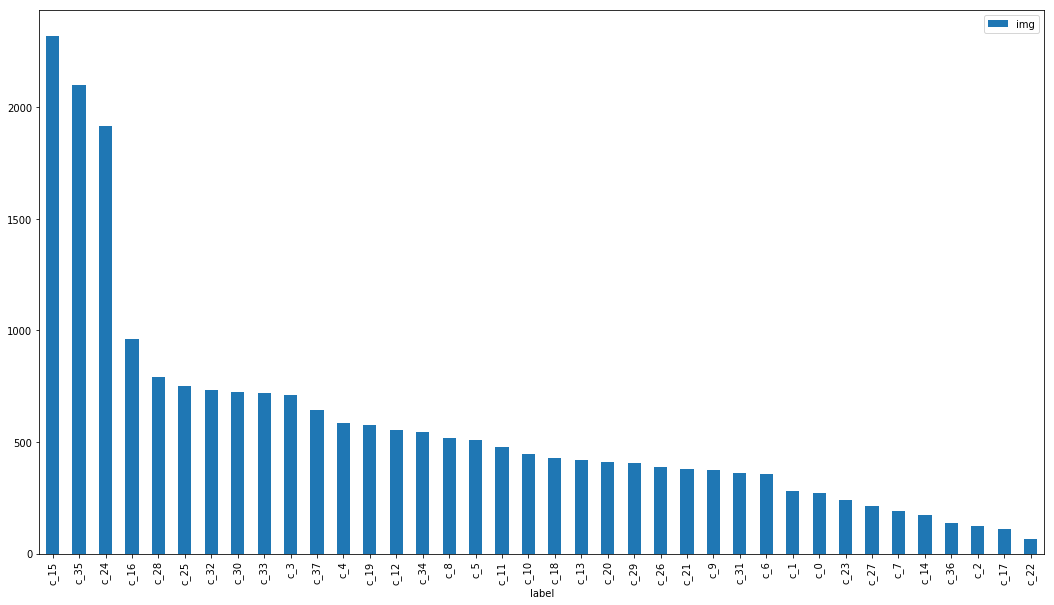

In [9]:
df_grouped.plot.bar(x ='label', figsize=(18,10))

In [10]:
df_grouped.describe()

,img
count,38.000000
mean,576.763158
std,505.201027
min,64.000000
25%,299.500000
50%,436.500000
75%,695.500000
max,2321.000000


The data is completely imbalanced, for that reason, must be find an approach to handle with this imbalances before the feed the Neural network. 

https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

Oversampling with gans

https://github.com/JeffersonLPLima/adversarial_oversampling


https://medium.com/neuralspace/kaggle-1-winning-approach-for-image-classification-challenge-9c1188157a86


https://github.com/kumar-shridhar/CNN_Architectures/blob/master/Resnet50/resnet50.ipynb

I make a copy of dataframe with file data information

In [11]:
k = 695
k

695

In [12]:
df2 =pd.DataFrame(columns=['label','img'])
for index,row in df_grouped.iterrows():
    df_aux = df[df.label == row['label']].copy()
    if len(df_aux) > k:
        df_sample = df_aux.sample(n=k).reset_index(drop=True)
    else:
        df_sample = df_aux
    print(df_sample.shape)
    df2 = df2.append(df_sample,ignore_index=True)
    #df_n = pd.concat([df2, df_n_aux],ignore_index=True) 
    print(df2.shape)

    
df2.shape
        #pd.concat([df]*3, ignore_index=True)

(695, 2)
(695, 2)
(695, 2)
(1390, 2)
(695, 2)
(2085, 2)
(695, 2)
(2780, 2)
(695, 2)
(3475, 2)
(695, 2)
(4170, 2)
(695, 2)
(4865, 2)
(695, 2)
(5560, 2)
(695, 2)
(6255, 2)
(695, 2)
(6950, 2)
(643, 2)
(7593, 2)
(586, 2)
(8179, 2)
(577, 2)
(8756, 2)
(552, 2)
(9308, 2)
(547, 2)
(9855, 2)
(519, 2)
(10374, 2)
(510, 2)
(10884, 2)
(476, 2)
(11360, 2)
(445, 2)
(11805, 2)
(428, 2)
(12233, 2)
(420, 2)
(12653, 2)
(412, 2)
(13065, 2)
(405, 2)
(13470, 2)
(390, 2)
(13860, 2)
(380, 2)
(14240, 2)
(374, 2)
(14614, 2)
(360, 2)
(14974, 2)
(358, 2)
(15332, 2)
(280, 2)
(15612, 2)
(270, 2)
(15882, 2)
(240, 2)
(16122, 2)
(214, 2)
(16336, 2)
(191, 2)
(16527, 2)
(171, 2)
(16698, 2)
(139, 2)
(16837, 2)
(124, 2)
(16961, 2)
(108, 2)
(17069, 2)
(64, 2)
(17133, 2)


(17133, 2)

In [13]:
df2.shape

(17133, 2)

In [14]:
df_grouped2 = df2.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped2

,label,img
24,c_30,695
26,c_32,695
23,c_3,695
21,c_28,695
27,c_33,695
18,c_25,695
17,c_24,695
7,c_15,695
8,c_16,695
29,c_35,695


In [15]:
df_grouped2.describe()

,img
count,38.000000
mean,450.868421
std,202.126422
min,64.000000
25%,299.500000
50%,436.500000
75%,682.000000
max,695.000000


In [16]:
X, y, label_encoder = load_img(df2)

Processing image:  1 ,  926e099c-8d2a-4d4b-8cb5-a5be62e25f2e___UF.Citrus_HLB_Lab 1159.JPG
Processing image:  1001 ,  2567dfac-4dbf-4ad8-a538-e239f15cefb0___YLCV_NREC 2337.JPG
Processing image:  2001 ,  1b283b99-e33d-4b1d-baf3-aa3d06305d1c___RS_HL 4286.JPG
Processing image:  3001 ,  53a586ef-8136-4f96-929e-f51c590a628c___UF.GRC_BS_Lab Leaf 0769.JPG
Processing image:  4001 ,  b51d73d1-874c-497b-8a84-e7317e27c871___UMD_Powd.M 9801.JPG
Processing image:  5001 ,  1f8743b6-f385-4464-9e41-48bd9fe85637___GHLB2 Leaf 8914.JPG
Processing image:  6001 ,  6eb67c67-b362-4be2-8257-27c8aba346d6___Com.G_SpM_FL 8907.JPG
Processing image:  7001 ,  30c8f7b8-e0cf-4cfb-b7fe-e2b75ce22789___GH_HL Leaf 333.1.JPG
Processing image:  8001 ,  44429437-288d-44cf-9aee-cdc89b7dc1ec___RS_HL 5397.JPG
Processing image:  9001 ,  3306483f-5feb-42e3-9c39-0a0b29ac1959___FAM_B.Msls 1767.JPG
Processing image:  10001 ,  5d94d29c-5831-4b75-bf31-0598e61b9bd1___RS_Rust 2028.JPG
Processing image:  11001 ,  9a668952-936a-4d6e-8cda-

In [17]:
_, NUM_CLASSES = y.shape
NUM_CLASSES

38

In [18]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123)

In [19]:
# Image Standarization

data_generator = image.ImageDataGenerator(rescale=1./255,
                                          rotation_range=75,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          featurewise_center=True,
                                          featurewise_std_normalization=True,
                                          horizontal_flip=True,
                                          zoom_range=0.3,
                                          samplewise_std_normalization=True)

data_generator.fit(X_train)

# standardize the test set
for i in range(len(X_test)):
    X_test[i] = data_generator.standardize(X_test[i])

## Neural Network Model

In [20]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

The first mode to train is a Resnet 50 with original data.

In [21]:
# Resnet50 model
base_model = ResNet50(input_shape=(64, 64, 3),include_top=False,weights= 'imagenet')

print(base_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________

In [22]:
# https://www.kaggle.com/amadeus1996/fruits-360-transfer-learning-using-keras

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
#x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = Model(inputs=base_model.input, outputs=predictions)

In [23]:
inception_transfer.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['acc'])

In [24]:
# https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://keras.io/models/sequential/
batch_size=256
epochs = 2500
ini = tm.time()

history =inception_transfer.fit_generator(
    generator=data_generator.flow(x=X_train,
                                  y=y_train,
                                  batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    shuffle = True, 
    verbose = 1,
    validation_data=(X_test, y_test))
end = tm.time()

elapsed = end - ini
print(elapsed/3600)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2500
53/53 [==============================] - 22s 417ms/step - loss: 1.9091 - acc: 0.5369 - val_loss: 0.9820 - val_acc: 0.7193
Epoch 2/2500
53/53 [==============================] - 15s 279ms/step - loss: 0.8688 - acc: 0.7559 - val_loss: 0.6322 - val_acc: 0.8337
Epoch 3/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.7962 - acc: 0.7722 - val_loss: 0.4669 - val_acc: 0.8666
Epoch 4/2500
53/53 [==============================] - 14s 260ms/step - loss: 0.5949 - acc: 0.8373 - val_loss: 0.4330 - val_acc: 0.8891
Epoch 5/2500
53/53 [==============================] - 14s 260ms/step - loss: 0.8152 - acc: 0.7711 - val_loss: 0.5115 - val_acc: 0.8480
Epoch 6/2500
53/53 [==============================] - 14s 261ms/step - loss: 0.7769 - acc: 0.7874 - val_loss: 0.8784 - val_acc: 0.7917
Epoch 7/2500
53/53 [==============================] - 14s 262ms/step - loss: 0.9680 - acc: 0.7315 - val_loss: 0.6360 - val_acc: 0.8153
Epoch 8

53/53 [==============================] - 14s 258ms/step - loss: 0.0796 - acc: 0.9729 - val_loss: 0.1023 - val_acc: 0.9708
Epoch 60/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0809 - acc: 0.9752 - val_loss: 0.0822 - val_acc: 0.9755
Epoch 61/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0764 - acc: 0.9747 - val_loss: 0.0917 - val_acc: 0.9726
Epoch 62/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0720 - acc: 0.9764 - val_loss: 0.0938 - val_acc: 0.9691
Epoch 63/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0754 - acc: 0.9745 - val_loss: 0.0847 - val_acc: 0.9746
Epoch 64/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0683 - acc: 0.9780 - val_loss: 0.1009 - val_acc: 0.9702
Epoch 65/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0802 - acc: 0.9754 - val_loss: 0.0759 - val_acc: 0.9740
Epoch 66/2500
53/53 [==============================] - 14s 257

53/53 [==============================] - 14s 258ms/step - loss: 0.0495 - acc: 0.9842 - val_loss: 0.0946 - val_acc: 0.9758
Epoch 120/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0528 - acc: 0.9830 - val_loss: 0.0946 - val_acc: 0.9714
Epoch 121/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0531 - acc: 0.9829 - val_loss: 0.0793 - val_acc: 0.9778
Epoch 122/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0551 - acc: 0.9831 - val_loss: 0.0931 - val_acc: 0.9723
Epoch 123/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0497 - acc: 0.9837 - val_loss: 0.1027 - val_acc: 0.9740
Epoch 124/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0646 - acc: 0.9793 - val_loss: 0.1038 - val_acc: 0.9714
Epoch 125/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0521 - acc: 0.9835 - val_loss: 0.0907 - val_acc: 0.9781
Epoch 126/2500
53/53 [==============================] - 

Epoch 179/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0337 - acc: 0.9889 - val_loss: 0.0787 - val_acc: 0.9807
Epoch 180/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0305 - acc: 0.9904 - val_loss: 0.0733 - val_acc: 0.9825
Epoch 181/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0290 - acc: 0.9899 - val_loss: 0.0765 - val_acc: 0.9802
Epoch 182/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0416 - acc: 0.9879 - val_loss: 0.0828 - val_acc: 0.9775
Epoch 183/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0430 - acc: 0.9849 - val_loss: 0.0640 - val_acc: 0.9799
Epoch 184/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0423 - acc: 0.9874 - val_loss: 0.0666 - val_acc: 0.9810
Epoch 185/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0353 - acc: 0.9888 - val_loss: 0.0613 - val_acc: 0.9840
Epoch 186/2500
53/53 [===================

Epoch 239/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0205 - acc: 0.9938 - val_loss: 0.0631 - val_acc: 0.9819
Epoch 240/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0743 - val_acc: 0.9790
Epoch 241/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0227 - acc: 0.9925 - val_loss: 0.0752 - val_acc: 0.9761
Epoch 242/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0205 - acc: 0.9926 - val_loss: 0.0786 - val_acc: 0.9799
Epoch 243/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0270 - acc: 0.9915 - val_loss: 0.0805 - val_acc: 0.9799
Epoch 244/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0297 - acc: 0.9903 - val_loss: 0.0818 - val_acc: 0.9807
Epoch 245/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0291 - acc: 0.9900 - val_loss: 0.0782 - val_acc: 0.9799
Epoch 246/2500
53/53 [===================

Epoch 299/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0281 - acc: 0.9912 - val_loss: 0.1082 - val_acc: 0.9764
Epoch 300/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0249 - acc: 0.9921 - val_loss: 0.0928 - val_acc: 0.9784
Epoch 301/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0298 - acc: 0.9906 - val_loss: 0.0780 - val_acc: 0.9790
Epoch 302/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0286 - acc: 0.9915 - val_loss: 0.0710 - val_acc: 0.9810
Epoch 303/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0206 - acc: 0.9935 - val_loss: 0.0667 - val_acc: 0.9819
Epoch 304/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0212 - acc: 0.9936 - val_loss: 0.0716 - val_acc: 0.9810
Epoch 305/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0295 - acc: 0.9914 - val_loss: 0.0923 - val_acc: 0.9796
Epoch 306/2500
53/53 [===================

Epoch 359/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0217 - acc: 0.9937 - val_loss: 0.0612 - val_acc: 0.9848
Epoch 360/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0236 - acc: 0.9920 - val_loss: 0.0647 - val_acc: 0.9872
Epoch 361/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0229 - acc: 0.9931 - val_loss: 0.0481 - val_acc: 0.9872
Epoch 362/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0232 - acc: 0.9930 - val_loss: 0.0526 - val_acc: 0.9880
Epoch 363/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0162 - acc: 0.9948 - val_loss: 0.0705 - val_acc: 0.9834
Epoch 364/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0618 - acc: 0.9848 - val_loss: 0.0782 - val_acc: 0.9769
Epoch 365/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0406 - acc: 0.9867 - val_loss: 0.0867 - val_acc: 0.9816
Epoch 366/2500
53/53 [===================

Epoch 419/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0205 - acc: 0.9939 - val_loss: 0.0616 - val_acc: 0.9848
Epoch 420/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0164 - acc: 0.9947 - val_loss: 0.0592 - val_acc: 0.9825
Epoch 421/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0191 - acc: 0.9945 - val_loss: 0.0631 - val_acc: 0.9834
Epoch 422/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0151 - acc: 0.9954 - val_loss: 0.0698 - val_acc: 0.9822
Epoch 423/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0593 - val_acc: 0.9837
Epoch 424/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0198 - acc: 0.9946 - val_loss: 0.0749 - val_acc: 0.9819
Epoch 425/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0121 - acc: 0.9957 - val_loss: 0.0783 - val_acc: 0.9834
Epoch 426/2500
53/53 [===================

Epoch 479/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0207 - acc: 0.9945 - val_loss: 0.0740 - val_acc: 0.9837
Epoch 480/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0182 - acc: 0.9947 - val_loss: 0.0740 - val_acc: 0.9842
Epoch 481/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0116 - acc: 0.9961 - val_loss: 0.0767 - val_acc: 0.9842
Epoch 482/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0156 - acc: 0.9951 - val_loss: 0.0699 - val_acc: 0.9822
Epoch 483/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0172 - acc: 0.9956 - val_loss: 0.0700 - val_acc: 0.9860
Epoch 484/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0155 - acc: 0.9944 - val_loss: 0.0638 - val_acc: 0.9854
Epoch 485/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0184 - acc: 0.9952 - val_loss: 0.0701 - val_acc: 0.9804
Epoch 486/2500
53/53 [===================

Epoch 539/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0160 - acc: 0.9954 - val_loss: 0.0735 - val_acc: 0.9834
Epoch 540/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0163 - acc: 0.9954 - val_loss: 0.0954 - val_acc: 0.9842
Epoch 541/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0536 - val_acc: 0.9889
Epoch 542/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0173 - acc: 0.9951 - val_loss: 0.0749 - val_acc: 0.9845
Epoch 543/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0295 - acc: 0.9944 - val_loss: 0.1652 - val_acc: 0.9737
Epoch 544/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.3497 - acc: 0.9236 - val_loss: 0.2532 - val_acc: 0.9451
Epoch 545/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.3050 - acc: 0.9318 - val_loss: 0.1978 - val_acc: 0.9603
Epoch 546/2500
53/53 [===================

Epoch 599/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0114 - acc: 0.9963 - val_loss: 0.0725 - val_acc: 0.9848
Epoch 600/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0132 - acc: 0.9965 - val_loss: 0.0734 - val_acc: 0.9857
Epoch 601/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0111 - acc: 0.9963 - val_loss: 0.0733 - val_acc: 0.9837
Epoch 602/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0130 - acc: 0.9963 - val_loss: 0.0900 - val_acc: 0.9851
Epoch 603/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0164 - acc: 0.9951 - val_loss: 0.0702 - val_acc: 0.9863
Epoch 604/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0179 - acc: 0.9955 - val_loss: 0.0790 - val_acc: 0.9848
Epoch 605/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0191 - acc: 0.9957 - val_loss: 0.0860 - val_acc: 0.9840
Epoch 606/2500
53/53 [===================

Epoch 659/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0183 - acc: 0.9952 - val_loss: 0.0693 - val_acc: 0.9845
Epoch 660/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0130 - acc: 0.9962 - val_loss: 0.0687 - val_acc: 0.9877
Epoch 661/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0147 - acc: 0.9955 - val_loss: 0.0624 - val_acc: 0.9863
Epoch 662/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0225 - acc: 0.9943 - val_loss: 0.0782 - val_acc: 0.9819
Epoch 663/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0184 - acc: 0.9953 - val_loss: 0.0656 - val_acc: 0.9842
Epoch 664/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0212 - acc: 0.9943 - val_loss: 0.0661 - val_acc: 0.9840
Epoch 665/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0153 - acc: 0.9955 - val_loss: 0.0591 - val_acc: 0.9863
Epoch 666/2500
53/53 [===================

Epoch 719/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0305 - acc: 0.9905 - val_loss: 0.0833 - val_acc: 0.9804
Epoch 720/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0252 - acc: 0.9920 - val_loss: 0.0890 - val_acc: 0.9793
Epoch 721/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0342 - acc: 0.9921 - val_loss: 0.0785 - val_acc: 0.9819
Epoch 722/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0297 - acc: 0.9928 - val_loss: 0.0772 - val_acc: 0.9819
Epoch 723/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0211 - acc: 0.9948 - val_loss: 0.0810 - val_acc: 0.9804
Epoch 724/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0151 - acc: 0.9954 - val_loss: 0.0777 - val_acc: 0.9828
Epoch 725/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0154 - acc: 0.9957 - val_loss: 0.0734 - val_acc: 0.9845
Epoch 726/2500
53/53 [===================

Epoch 779/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0767 - val_acc: 0.9831
Epoch 780/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0116 - acc: 0.9966 - val_loss: 0.0785 - val_acc: 0.9848
Epoch 781/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0107 - acc: 0.9967 - val_loss: 0.0679 - val_acc: 0.9857
Epoch 782/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0081 - acc: 0.9977 - val_loss: 0.0717 - val_acc: 0.9854
Epoch 783/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0073 - acc: 0.9977 - val_loss: 0.0779 - val_acc: 0.9837
Epoch 784/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0094 - acc: 0.9976 - val_loss: 0.0648 - val_acc: 0.9860
Epoch 785/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0128 - acc: 0.9970 - val_loss: 0.0655 - val_acc: 0.9845
Epoch 786/2500
53/53 [===================

Epoch 839/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0154 - acc: 0.9960 - val_loss: 0.0921 - val_acc: 0.9845
Epoch 840/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0194 - acc: 0.9958 - val_loss: 0.0956 - val_acc: 0.9819
Epoch 841/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0224 - acc: 0.9954 - val_loss: 0.0852 - val_acc: 0.9842
Epoch 842/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0163 - acc: 0.9956 - val_loss: 0.0825 - val_acc: 0.9834
Epoch 843/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0155 - acc: 0.9957 - val_loss: 0.0688 - val_acc: 0.9825
Epoch 844/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0142 - acc: 0.9952 - val_loss: 0.0963 - val_acc: 0.9804
Epoch 845/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0215 - acc: 0.9940 - val_loss: 0.0921 - val_acc: 0.9840
Epoch 846/2500
53/53 [===================

Epoch 899/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0118 - acc: 0.9968 - val_loss: 0.0813 - val_acc: 0.9863
Epoch 900/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0137 - acc: 0.9962 - val_loss: 0.0885 - val_acc: 0.9851
Epoch 901/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0286 - acc: 0.9946 - val_loss: 0.0723 - val_acc: 0.9840
Epoch 902/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0467 - acc: 0.9940 - val_loss: 0.1359 - val_acc: 0.9807
Epoch 903/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0783 - acc: 0.9854 - val_loss: 0.1043 - val_acc: 0.9746
Epoch 904/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0332 - acc: 0.9922 - val_loss: 0.0842 - val_acc: 0.9845
Epoch 905/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0222 - acc: 0.9951 - val_loss: 0.0737 - val_acc: 0.9848
Epoch 906/2500
53/53 [===================

Epoch 959/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0680 - acc: 0.9905 - val_loss: 0.1554 - val_acc: 0.9778
Epoch 960/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.1071 - acc: 0.9834 - val_loss: 0.1512 - val_acc: 0.9702
Epoch 961/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.1198 - acc: 0.9736 - val_loss: 0.1461 - val_acc: 0.9761
Epoch 962/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.2430 - acc: 0.9512 - val_loss: 0.1676 - val_acc: 0.9583
Epoch 963/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0823 - acc: 0.9800 - val_loss: 0.1516 - val_acc: 0.9734
Epoch 964/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0651 - acc: 0.9853 - val_loss: 0.1051 - val_acc: 0.9778
Epoch 965/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0313 - acc: 0.9914 - val_loss: 0.0809 - val_acc: 0.9819
Epoch 966/2500
53/53 [===================

53/53 [==============================] - 14s 258ms/step - loss: 0.0929 - acc: 0.9871 - val_loss: 0.1101 - val_acc: 0.9778
Epoch 1019/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0668 - acc: 0.9910 - val_loss: 0.1145 - val_acc: 0.9793
Epoch 1020/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0638 - acc: 0.9880 - val_loss: 0.1628 - val_acc: 0.9676
Epoch 1021/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0848 - acc: 0.9796 - val_loss: 0.1245 - val_acc: 0.9758
Epoch 1022/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0422 - acc: 0.9916 - val_loss: 0.1015 - val_acc: 0.9810
Epoch 1023/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.1816 - acc: 0.9581 - val_loss: 0.1584 - val_acc: 0.9688
Epoch 1024/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.1057 - acc: 0.9792 - val_loss: 0.1478 - val_acc: 0.9685
Epoch 1025/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.0758 - val_acc: 0.9875
Epoch 1078/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0081 - acc: 0.9974 - val_loss: 0.0787 - val_acc: 0.9863
Epoch 1079/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0074 - acc: 0.9983 - val_loss: 0.0753 - val_acc: 0.9869
Epoch 1080/2500
53/53 [==============================] - 14s 260ms/step - loss: 0.0095 - acc: 0.9978 - val_loss: 0.0826 - val_acc: 0.9845
Epoch 1081/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0096 - acc: 0.9974 - val_loss: 0.0942 - val_acc: 0.9842
Epoch 1082/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 0.0881 - val_acc: 0.9866
Epoch 1083/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0088 - acc: 0.9979 - val_loss: 0.0867 - val_acc: 0.9857
Epoch 1084/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0132 - acc: 0.9968 - val_loss: 0.0801 - val_acc: 0.9845
Epoch 1137/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0115 - acc: 0.9971 - val_loss: 0.0686 - val_acc: 0.9872
Epoch 1138/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.0727 - val_acc: 0.9898
Epoch 1139/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0125 - acc: 0.9971 - val_loss: 0.0659 - val_acc: 0.9877
Epoch 1140/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0137 - acc: 0.9960 - val_loss: 0.0925 - val_acc: 0.9834
Epoch 1141/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0158 - acc: 0.9959 - val_loss: 0.0740 - val_acc: 0.9845
Epoch 1142/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0142 - acc: 0.9960 - val_loss: 0.0903 - val_acc: 0.9837
Epoch 1143/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0186 - acc: 0.9959 - val_loss: 0.0778 - val_acc: 0.9866
Epoch 1196/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0128 - acc: 0.9968 - val_loss: 0.0841 - val_acc: 0.9860
Epoch 1197/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0085 - acc: 0.9978 - val_loss: 0.0839 - val_acc: 0.9886
Epoch 1198/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0147 - acc: 0.9968 - val_loss: 0.0765 - val_acc: 0.9854
Epoch 1199/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0079 - acc: 0.9972 - val_loss: 0.0735 - val_acc: 0.9877
Epoch 1200/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0078 - acc: 0.9978 - val_loss: 0.0762 - val_acc: 0.9875
Epoch 1201/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0069 - acc: 0.9974 - val_loss: 0.0778 - val_acc: 0.9869
Epoch 1202/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0126 - acc: 0.9966 - val_loss: 0.0762 - val_acc: 0.9875
Epoch 1255/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0170 - acc: 0.9958 - val_loss: 0.0997 - val_acc: 0.9842
Epoch 1256/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0113 - acc: 0.9966 - val_loss: 0.0911 - val_acc: 0.9840
Epoch 1257/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0141 - acc: 0.9975 - val_loss: 0.0942 - val_acc: 0.9837
Epoch 1258/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0127 - acc: 0.9968 - val_loss: 0.0909 - val_acc: 0.9854
Epoch 1259/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.0663 - val_acc: 0.9872
Epoch 1260/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0082 - acc: 0.9976 - val_loss: 0.0784 - val_acc: 0.9875
Epoch 1261/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0160 - acc: 0.9968 - val_loss: 0.0967 - val_acc: 0.9842
Epoch 1314/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0509 - acc: 0.9918 - val_loss: 0.1149 - val_acc: 0.9790
Epoch 1315/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0868 - acc: 0.9834 - val_loss: 0.1106 - val_acc: 0.9752
Epoch 1316/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0416 - acc: 0.9906 - val_loss: 0.1100 - val_acc: 0.9799
Epoch 1317/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0207 - acc: 0.9943 - val_loss: 0.1177 - val_acc: 0.9787
Epoch 1318/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0178 - acc: 0.9957 - val_loss: 0.0884 - val_acc: 0.9822
Epoch 1319/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0145 - acc: 0.9961 - val_loss: 0.0851 - val_acc: 0.9840
Epoch 1320/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0070 - acc: 0.9981 - val_loss: 0.0594 - val_acc: 0.9875
Epoch 1373/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0037 - acc: 0.9987 - val_loss: 0.0856 - val_acc: 0.9875
Epoch 1374/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0083 - acc: 0.9977 - val_loss: 0.0797 - val_acc: 0.9866
Epoch 1375/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0102 - acc: 0.9976 - val_loss: 0.0805 - val_acc: 0.9857
Epoch 1376/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0710 - val_acc: 0.9872
Epoch 1377/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0089 - acc: 0.9976 - val_loss: 0.0784 - val_acc: 0.9857
Epoch 1378/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0076 - acc: 0.9980 - val_loss: 0.0739 - val_acc: 0.9854
Epoch 1379/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0119 - acc: 0.9981 - val_loss: 0.0698 - val_acc: 0.9866
Epoch 1432/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0084 - acc: 0.9977 - val_loss: 0.0721 - val_acc: 0.9857
Epoch 1433/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0088 - acc: 0.9979 - val_loss: 0.0823 - val_acc: 0.9810
Epoch 1434/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0077 - acc: 0.9979 - val_loss: 0.0760 - val_acc: 0.9854
Epoch 1435/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0059 - acc: 0.9984 - val_loss: 0.0688 - val_acc: 0.9866
Epoch 1436/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0645 - val_acc: 0.9883
Epoch 1437/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0068 - acc: 0.9987 - val_loss: 0.0733 - val_acc: 0.9889
Epoch 1438/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0076 - acc: 0.9977 - val_loss: 0.0775 - val_acc: 0.9848
Epoch 1491/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0100 - acc: 0.9978 - val_loss: 0.0801 - val_acc: 0.9842
Epoch 1492/2500
53/53 [==============================] - 14s 256ms/step - loss: 0.0115 - acc: 0.9972 - val_loss: 0.0787 - val_acc: 0.9863
Epoch 1493/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0070 - acc: 0.9982 - val_loss: 0.0765 - val_acc: 0.9866
Epoch 1494/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0066 - acc: 0.9984 - val_loss: 0.0784 - val_acc: 0.9863
Epoch 1495/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0066 - acc: 0.9984 - val_loss: 0.0786 - val_acc: 0.9866
Epoch 1496/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0051 - acc: 0.9983 - val_loss: 0.0876 - val_acc: 0.9860
Epoch 1497/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0057 - acc: 0.9983 - val_loss: 0.0829 - val_acc: 0.9869
Epoch 1550/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.0696 - val_acc: 0.9877
Epoch 1551/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0094 - acc: 0.9982 - val_loss: 0.0802 - val_acc: 0.9863
Epoch 1552/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0063 - acc: 0.9984 - val_loss: 0.0614 - val_acc: 0.9895
Epoch 1553/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0072 - acc: 0.9979 - val_loss: 0.0646 - val_acc: 0.9901
Epoch 1554/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0085 - acc: 0.9974 - val_loss: 0.0618 - val_acc: 0.9901
Epoch 1555/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0723 - val_acc: 0.9892
Epoch 1556/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0191 - acc: 0.9963 - val_loss: 0.1186 - val_acc: 0.9825
Epoch 1609/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0278 - acc: 0.9946 - val_loss: 0.0970 - val_acc: 0.9851
Epoch 1610/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0138 - acc: 0.9970 - val_loss: 0.0993 - val_acc: 0.9866
Epoch 1611/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0139 - acc: 0.9967 - val_loss: 0.0990 - val_acc: 0.9831
Epoch 1612/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0091 - acc: 0.9974 - val_loss: 0.1057 - val_acc: 0.9854
Epoch 1613/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0079 - acc: 0.9980 - val_loss: 0.0948 - val_acc: 0.9845
Epoch 1614/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0090 - acc: 0.9977 - val_loss: 0.0847 - val_acc: 0.9863
Epoch 1615/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0071 - acc: 0.9982 - val_loss: 0.0908 - val_acc: 0.9869
Epoch 1668/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0134 - acc: 0.9971 - val_loss: 0.0856 - val_acc: 0.9877
Epoch 1669/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0207 - acc: 0.9966 - val_loss: 0.1041 - val_acc: 0.9828
Epoch 1670/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0200 - acc: 0.9959 - val_loss: 0.0910 - val_acc: 0.9860
Epoch 1671/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0127 - acc: 0.9973 - val_loss: 0.0811 - val_acc: 0.9857
Epoch 1672/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0113 - acc: 0.9975 - val_loss: 0.0915 - val_acc: 0.9857
Epoch 1673/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0102 - acc: 0.9974 - val_loss: 0.0928 - val_acc: 0.9857
Epoch 1674/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0084 - acc: 0.9983 - val_loss: 0.0816 - val_acc: 0.9851
Epoch 1727/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0047 - acc: 0.9984 - val_loss: 0.0910 - val_acc: 0.9872
Epoch 1728/2500
53/53 [==============================] - 14s 260ms/step - loss: 0.0064 - acc: 0.9983 - val_loss: 0.0830 - val_acc: 0.9886
Epoch 1729/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0096 - acc: 0.9976 - val_loss: 0.0971 - val_acc: 0.9854
Epoch 1730/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0102 - acc: 0.9981 - val_loss: 0.1001 - val_acc: 0.9851
Epoch 1731/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0154 - acc: 0.9960 - val_loss: 0.0791 - val_acc: 0.9872
Epoch 1732/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0136 - acc: 0.9968 - val_loss: 0.0711 - val_acc: 0.9866
Epoch 1733/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0695 - val_acc: 0.9869
Epoch 1786/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0049 - acc: 0.9984 - val_loss: 0.0753 - val_acc: 0.9869
Epoch 1787/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0112 - acc: 0.9975 - val_loss: 0.0647 - val_acc: 0.9854
Epoch 1788/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0115 - acc: 0.9972 - val_loss: 0.0651 - val_acc: 0.9857
Epoch 1789/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0760 - val_acc: 0.9880
Epoch 1790/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0066 - acc: 0.9982 - val_loss: 0.0893 - val_acc: 0.9851
Epoch 1791/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0098 - acc: 0.9979 - val_loss: 0.0833 - val_acc: 0.9857
Epoch 1792/2500
53/53 [===========================

53/53 [==============================] - 14s 268ms/step - loss: 0.0072 - acc: 0.9976 - val_loss: 0.0847 - val_acc: 0.9869
Epoch 1845/2500
53/53 [==============================] - 14s 264ms/step - loss: 0.0069 - acc: 0.9982 - val_loss: 0.0998 - val_acc: 0.9860
Epoch 1846/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0072 - acc: 0.9981 - val_loss: 0.1069 - val_acc: 0.9869
Epoch 1847/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0100 - acc: 0.9975 - val_loss: 0.0939 - val_acc: 0.9869
Epoch 1848/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0067 - acc: 0.9982 - val_loss: 0.0929 - val_acc: 0.9877
Epoch 1849/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0076 - acc: 0.9982 - val_loss: 0.1075 - val_acc: 0.9863
Epoch 1850/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0083 - acc: 0.9976 - val_loss: 0.0945 - val_acc: 0.9875
Epoch 1851/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.0754 - val_acc: 0.9875
Epoch 1904/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0067 - acc: 0.9982 - val_loss: 0.0801 - val_acc: 0.9875
Epoch 1905/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0095 - acc: 0.9980 - val_loss: 0.0760 - val_acc: 0.9866
Epoch 1906/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0100 - acc: 0.9982 - val_loss: 0.0734 - val_acc: 0.9883
Epoch 1907/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0117 - acc: 0.9971 - val_loss: 0.0759 - val_acc: 0.9854
Epoch 1908/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0088 - acc: 0.9982 - val_loss: 0.0688 - val_acc: 0.9883
Epoch 1909/2500
53/53 [==============================] - 14s 256ms/step - loss: 0.0054 - acc: 0.9988 - val_loss: 0.0730 - val_acc: 0.9886
Epoch 1910/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0529 - acc: 0.9876 - val_loss: 0.1170 - val_acc: 0.9796
Epoch 1963/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0484 - acc: 0.9892 - val_loss: 0.1071 - val_acc: 0.9802
Epoch 1964/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0291 - acc: 0.9929 - val_loss: 0.0991 - val_acc: 0.9813
Epoch 1965/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0262 - acc: 0.9937 - val_loss: 0.1159 - val_acc: 0.9810
Epoch 1966/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0289 - acc: 0.9945 - val_loss: 0.1052 - val_acc: 0.9813
Epoch 1967/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0182 - acc: 0.9962 - val_loss: 0.1072 - val_acc: 0.9813
Epoch 1968/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0221 - acc: 0.9953 - val_loss: 0.1034 - val_acc: 0.9819
Epoch 1969/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0066 - acc: 0.9981 - val_loss: 0.0842 - val_acc: 0.9880
Epoch 2022/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0824 - val_acc: 0.9877
Epoch 2023/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0070 - acc: 0.9985 - val_loss: 0.0814 - val_acc: 0.9875
Epoch 2024/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0060 - acc: 0.9984 - val_loss: 0.0906 - val_acc: 0.9869
Epoch 2025/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0077 - acc: 0.9983 - val_loss: 0.0923 - val_acc: 0.9863
Epoch 2026/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0890 - val_acc: 0.9877
Epoch 2027/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0096 - acc: 0.9981 - val_loss: 0.0885 - val_acc: 0.9869
Epoch 2028/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0080 - acc: 0.9981 - val_loss: 0.0845 - val_acc: 0.9883
Epoch 2081/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0109 - acc: 0.9977 - val_loss: 0.0920 - val_acc: 0.9875
Epoch 2082/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0107 - acc: 0.9982 - val_loss: 0.0873 - val_acc: 0.9872
Epoch 2083/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0084 - acc: 0.9981 - val_loss: 0.0992 - val_acc: 0.9860
Epoch 2084/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.1004 - val_acc: 0.9877
Epoch 2085/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0054 - acc: 0.9986 - val_loss: 0.0940 - val_acc: 0.9886
Epoch 2086/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0063 - acc: 0.9990 - val_loss: 0.0845 - val_acc: 0.9883
Epoch 2087/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0354 - acc: 0.9910 - val_loss: 0.1093 - val_acc: 0.9840
Epoch 2140/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0178 - acc: 0.9950 - val_loss: 0.1067 - val_acc: 0.9840
Epoch 2141/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0158 - acc: 0.9965 - val_loss: 0.1086 - val_acc: 0.9860
Epoch 2142/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0122 - acc: 0.9970 - val_loss: 0.1060 - val_acc: 0.9851
Epoch 2143/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0094 - acc: 0.9979 - val_loss: 0.1012 - val_acc: 0.9860
Epoch 2144/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0093 - acc: 0.9977 - val_loss: 0.1076 - val_acc: 0.9834
Epoch 2145/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0088 - acc: 0.9974 - val_loss: 0.1095 - val_acc: 0.9848
Epoch 2146/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0040 - acc: 0.9991 - val_loss: 0.0945 - val_acc: 0.9869
Epoch 2199/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0048 - acc: 0.9992 - val_loss: 0.0891 - val_acc: 0.9892
Epoch 2200/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0050 - acc: 0.9987 - val_loss: 0.0914 - val_acc: 0.9892
Epoch 2201/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.1063 - val_acc: 0.9863
Epoch 2202/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0111 - acc: 0.9980 - val_loss: 0.0924 - val_acc: 0.9883
Epoch 2203/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0083 - acc: 0.9980 - val_loss: 0.0962 - val_acc: 0.9883
Epoch 2204/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0115 - acc: 0.9978 - val_loss: 0.1125 - val_acc: 0.9857
Epoch 2205/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0083 - acc: 0.9978 - val_loss: 0.0919 - val_acc: 0.9866
Epoch 2258/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0075 - acc: 0.9982 - val_loss: 0.1023 - val_acc: 0.9877
Epoch 2259/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0075 - acc: 0.9987 - val_loss: 0.0879 - val_acc: 0.9892
Epoch 2260/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0055 - acc: 0.9985 - val_loss: 0.1068 - val_acc: 0.9883
Epoch 2261/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0094 - acc: 0.9979 - val_loss: 0.1044 - val_acc: 0.9880
Epoch 2262/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0123 - acc: 0.9978 - val_loss: 0.1034 - val_acc: 0.9880
Epoch 2263/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0239 - acc: 0.9969 - val_loss: 0.1251 - val_acc: 0.9848
Epoch 2264/2500
53/53 [===========================

53/53 [==============================] - 14s 269ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.0884 - val_acc: 0.9877
Epoch 2317/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0950 - val_acc: 0.9854
Epoch 2318/2500
53/53 [==============================] - 14s 260ms/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0905 - val_acc: 0.9860
Epoch 2319/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0066 - acc: 0.9989 - val_loss: 0.0845 - val_acc: 0.9880
Epoch 2320/2500
53/53 [==============================] - 14s 260ms/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.0846 - val_acc: 0.9880
Epoch 2321/2500
53/53 [==============================] - 14s 261ms/step - loss: 0.0059 - acc: 0.9989 - val_loss: 0.1040 - val_acc: 0.9877
Epoch 2322/2500
53/53 [==============================] - 14s 262ms/step - loss: 0.0044 - acc: 0.9987 - val_loss: 0.1054 - val_acc: 0.9851
Epoch 2323/2500
53/53 [===========================

53/53 [==============================] - 14s 258ms/step - loss: 0.0120 - acc: 0.9973 - val_loss: 0.0993 - val_acc: 0.9863
Epoch 2376/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0084 - acc: 0.9979 - val_loss: 0.1213 - val_acc: 0.9837
Epoch 2377/2500
53/53 [==============================] - 14s 259ms/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.1047 - val_acc: 0.9883
Epoch 2378/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0089 - acc: 0.9977 - val_loss: 0.1128 - val_acc: 0.9872
Epoch 2379/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0148 - acc: 0.9971 - val_loss: 0.1131 - val_acc: 0.9845
Epoch 2380/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0078 - acc: 0.9981 - val_loss: 0.1012 - val_acc: 0.9880
Epoch 2381/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0092 - acc: 0.9981 - val_loss: 0.1099 - val_acc: 0.9866
Epoch 2382/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0299 - acc: 0.9959 - val_loss: 0.1160 - val_acc: 0.9816
Epoch 2435/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0321 - acc: 0.9952 - val_loss: 0.1180 - val_acc: 0.9807
Epoch 2436/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0283 - acc: 0.9958 - val_loss: 0.1118 - val_acc: 0.9828
Epoch 2437/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0216 - acc: 0.9959 - val_loss: 0.1163 - val_acc: 0.9834
Epoch 2438/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0204 - acc: 0.9970 - val_loss: 0.1184 - val_acc: 0.9816
Epoch 2439/2500
53/53 [==============================] - 14s 258ms/step - loss: 0.0181 - acc: 0.9971 - val_loss: 0.1129 - val_acc: 0.9837
Epoch 2440/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0178 - acc: 0.9971 - val_loss: 0.1050 - val_acc: 0.9819
Epoch 2441/2500
53/53 [===========================

53/53 [==============================] - 14s 257ms/step - loss: 0.0042 - acc: 0.9991 - val_loss: 0.0855 - val_acc: 0.9880
Epoch 2494/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0906 - val_acc: 0.9883
Epoch 2495/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 0.0927 - val_acc: 0.9883
Epoch 2496/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.1038 - val_acc: 0.9877
Epoch 2497/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0041 - acc: 0.9994 - val_loss: 0.1049 - val_acc: 0.9872
Epoch 2498/2500
53/53 [==============================] - 14s 256ms/step - loss: 0.0025 - acc: 0.9990 - val_loss: 0.0946 - val_acc: 0.9869
Epoch 2499/2500
53/53 [==============================] - 14s 257ms/step - loss: 0.0046 - acc: 0.9989 - val_loss: 0.0896 - val_acc: 0.9889
Epoch 2500/2500
53/53 [===========================

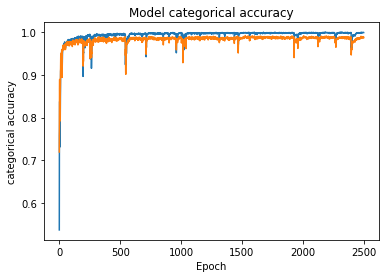

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()